In [2]:
import warnings
import json 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

import torch

from torchvision import transforms
from torch.utils.data import DataLoader, ConcatDataset
from torch.optim import AdamW

from transformers import get_scheduler
from sklearn.metrics import PredictionErrorDisplay

from jre_utils.config import asset_types
from jre_utils.datapath import model_ready_data_paths, model_output_data_paths, DATA_DIRECTORY_PATH
from jre_utils.process import get_most_active_municipalities
from jre_utils.data import JapanRETimeSeriesDataset, PadAndMask, ToNumpy, ToTensor
from jre_utils.models import TimeSeriesTransformerModel
from jre_utils.metrics import MSELossWeighted
from jre_utils.engine import (
    evaluate_weighted,
    train_weighted,
)
from jre_utils.backtest import predict_returns

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

/Users/diab/Desktop/japan_re/venv38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/diab/Desktop/japan_re/venv38/lib/python3.8/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


### Config


In [3]:
asset_type = "combined"
dataset_key = "transactions"
years_ahead = 2

metrics = {
    "median": "unit_price_median",
    "gmean": "unit_price_gmean",
}

granularity_columns = ["area", "area_code"]
group_by_columns = granularity_columns + ["year"]

metric_key = "gmean"
metric = metrics[metric_key]
metric_pct_chg = metric + "_pct_chg"

normalized_metric_pct_chg = metric_pct_chg + "_normalized_yearly"
log_normalized_metric_pct_chg = metric_pct_chg + "_log_normalized_yearly"

In [4]:
start_year = 2007
eval_start_year = 2021  # eval_years = [2021, 2022]
eval_end_year = 2022

dataset_name = f"sequence_{dataset_key}_{asset_type}_{metric_key}_{years_ahead}"
output_dataset_name = f"{dataset_name}_{eval_start_year}"
model_ready_data_path = model_ready_data_paths[dataset_name]
model_output_data_path = model_output_data_paths[output_dataset_name]

In [9]:
id_columns = ["area_code", "area", "year"]

original_factor_columns = [
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_log_normalize_columns = [
    "population",
    "taxable_income_growth",
    "taxable_income_per_taxpayer_growth",
    "net_migration_ratio",
    "new_dwellings_ratio",
    "taxpayer_count_growth",
]

factor_normalize_columns = []

factor_maintain_columns = [
    "migrations_is_available",
    "taxable_income_is_available",
    "dwellings_is_available",
    "total_tax_is_available",
]

factor_columns = (
    [f"{column}_log_normalized_yearly" for column in factor_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in factor_normalize_columns]
    + factor_maintain_columns
    # + original_factor_columns
)

final_factor_columns = (
    factor_normalize_columns + factor_log_normalize_columns + factor_columns
)

In [10]:
# asset_types_to_train = list(asset_types.keys())
asset_types_to_train = ["building"]
asset_types_as_factors = list(set(asset_types_to_train + ["building"]))

core_log_normalize_columns = ["yearly_price_growth"]
core_normalize_columns = ["count_growth"]
core_maintain_columns = ["metric_pct_chg_is_available"]

core_columns = (
    [f"{column}_log_normalized_yearly" for column in core_log_normalize_columns]
    + [f"{column}_normalized_yearly" for column in core_normalize_columns]
    + core_maintain_columns
)

combined_core_columns = [
    f"{asset_type}_{column}"
    for column in core_columns
    for asset_type in asset_types_as_factors
]

In [11]:
feature_columns = factor_columns + combined_core_columns + ["land", "condo"]

### Dataset Prep


In [12]:
df = pd.read_csv(model_ready_data_path)
df = df[df["year"] <= eval_end_year]
df = df.sample(frac=1).reset_index(drop=True)
df = df.sort_values(by=["year"]).reset_index(drop=True)
df = get_most_active_municipalities(df, count_column="building_count", n=1000)

df["area_code"] = df["area_code"].astype(str)

# Weighting by population
df["log_population"] = df["population"].apply(lambda x: np.log10(1 + x))
df["weight"] = df.groupby("year")["log_population"].transform(lambda x: x - x.min() + 1)

# Split into Train and Eval
train_df = df[(df["year"] >= start_year) & (df["year"] < eval_start_year)]
eval_df = df[df["year"] >= eval_start_year]

train_dfs = {
    asset_type: train_df[
        ~train_df[f"{asset_type}_{metric_pct_chg}"].isna()
    ].reset_index(drop=True)
    for asset_type in asset_types_to_train
}

eval_dfs = {
    asset_type: eval_df[~eval_df[f"{asset_type}_{metric_pct_chg}"].isna()].reset_index(
        drop=True
    )
    for asset_type in asset_types_to_train
}

# Finally
df = df.fillna(0)

for asset_type in asset_types_to_train:
    print(f"{asset_type} -> Train: {train_dfs[asset_type].shape}, Eval: {eval_dfs[asset_type].shape}")


building -> Train: (12112, 84), Eval: (2000, 84)


In [13]:
# df[df["area_code"] == "13101"][["year", "area_code", "area", "building_unit_price_gmean_pct_chg_normalized_yearly", "population_log_normalized_yearly"] + original_factor_columns].round(3).to_csv("sample.csv", index=False)

In [14]:
feature_columns

['population_log_normalized_yearly',
 'taxable_income_growth_log_normalized_yearly',
 'taxable_income_per_taxpayer_growth_log_normalized_yearly',
 'net_migration_ratio_log_normalized_yearly',
 'new_dwellings_ratio_log_normalized_yearly',
 'taxpayer_count_growth_log_normalized_yearly',
 'migrations_is_available',
 'taxable_income_is_available',
 'dwellings_is_available',
 'total_tax_is_available',
 'building_yearly_price_growth_log_normalized_yearly',
 'building_count_growth_normalized_yearly',
 'building_metric_pct_chg_is_available',
 'land',
 'condo']

<Axes: ylabel='Frequency'>

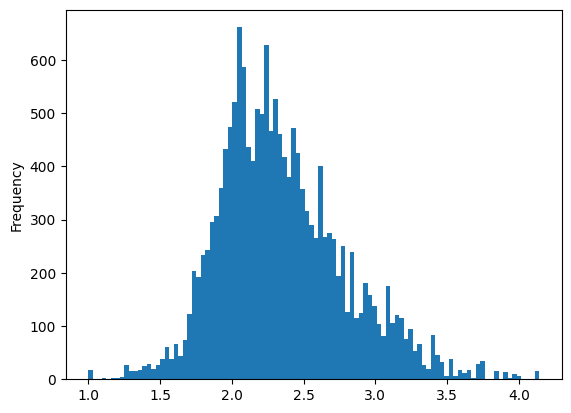

In [15]:
df["weight"].plot.hist(bins=100)

In [16]:
asset_type = "building"
tmp_train_df, tmp_eval_df = train_dfs[asset_type], eval_dfs[asset_type]
tmp_metric, tmp_metric_pct_chg, tmp_normalized_metric_pct_chg = (
    f"{asset_type}_{metric}",
    f"{asset_type}_{metric_pct_chg}",
    f"{asset_type}_{log_normalized_metric_pct_chg}",
)

tmp_train_df[(tmp_train_df["area_code"] == "13102")][
    ["year", tmp_metric, tmp_metric_pct_chg, tmp_normalized_metric_pct_chg]
]

,year,building_unit_price_gmean,building_unit_price_gmean_pct_chg,building_unit_price_gmean_pct_chg_log_normalized_yearly
24,2007,2.930576e+06,0.340367,0.824517
152,2008,2.615646e+06,0.346098,0.941139
542,2009,1.862297e+06,-0.364528,-1.087870
1776,2010,1.439064e+06,-0.449825,-1.428380
2791,2011,1.486421e+06,-0.201835,-0.583830
3729,2012,1.375874e+06,-0.043910,-0.029579
4487,2013,1.722702e+06,0.158959,0.538450
5948,2014,2.003999e+06,0.456528,1.143763
6712,2015,2.250190e+06,0.306198,0.823743
7654,2016,2.529195e+06,0.262074,0.626396


In [17]:
tmp_eval_df[(tmp_eval_df["area_code"] == "13102")][
    ["year", tmp_metric, tmp_metric_pct_chg, tmp_normalized_metric_pct_chg]
]

,year,building_unit_price_gmean,building_unit_price_gmean_pct_chg,building_unit_price_gmean_pct_chg_log_normalized_yearly
801,2021,2.816571e+06,-0.053462,-0.133839
1225,2022,3.951694e+06,0.228788,0.610076


In [22]:
from jre_utils.process import get_window

idx = tmp_eval_df[(tmp_eval_df["area_code"] == "13102")].index[-2]
row = tmp_eval_df.iloc[idx]
target = row[tmp_normalized_metric_pct_chg]
area_code, year = row["area_code"], row["year"]
window = get_window(df, area_code, year - years_ahead, 5)

print(f"Target: {target}")
window[factor_columns + combined_core_columns]
# window

Target: -0.1338394340306548


,population_log_normalized_yearly,taxable_income_growth_log_normalized_yearly,taxable_income_per_taxpayer_growth_log_normalized_yearly,net_migration_ratio_log_normalized_yearly,new_dwellings_ratio_log_normalized_yearly,taxpayer_count_growth_log_normalized_yearly,migrations_is_available,taxable_income_is_available,dwellings_is_available,total_tax_is_available,building_yearly_price_growth_log_normalized_yearly,building_count_growth_normalized_yearly,building_metric_pct_chg_is_available
11469,1.094578,1.181180,-0.165600,3.536982,1.902188,2.662955,1,1,1,1,0.296820,-0.164742,1.0
12704,1.110245,1.490954,0.894214,4.079340,7.613134,1.466553,1,1,1,1,0.358558,-0.149857,1.0
13883,1.130387,1.515889,0.557545,4.132062,1.530660,1.819093,1,1,1,1,0.334598,-0.575711,1.0
14705,1.151447,1.246128,0.216520,3.300576,4.411286,2.433750,1,1,1,1,0.369424,0.322578,1.0
16462,1.166419,2.205573,1.541510,3.242182,0.934724,1.958831,1,1,1,1,-0.147930,-0.303215,1.0


In [23]:
# window[["year", "area_code", "building_unit_price_gmean_pct_chg_normalized_yearly", "population_log_normalized_yearly"] + original_factor_columns].round(3).to_csv("sample.csv", index=False)

In [31]:
window_length = 10

In [32]:
time_series_dataset = JapanRETimeSeriesDataset(
    df,
    tmp_train_df,
    metrics=[tmp_normalized_metric_pct_chg],
    weight_column="weight",
    asset_type=asset_type,
    feature_columns=feature_columns,
    shift=years_ahead,
    window_length=window_length
)

time_series_dataset_transformed = JapanRETimeSeriesDataset(
    df,
    tmp_train_df,
    metrics=[tmp_normalized_metric_pct_chg],
    weight_column="weight",
    asset_type=asset_type,
    feature_columns=feature_columns,
    transform=transforms.Compose([ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]),
    shift=years_ahead,
    window_length=window_length
)

for i, sampleX in enumerate(time_series_dataset):
    print(
        i,
        sampleX["window"].shape,
        sampleX["target"].shape,
        sampleX["target"].values,
        sampleX["weight"].values,
    )
    if i == 3:
        break


for i, sampleY in enumerate(time_series_dataset_transformed):
    print(
        i,
        sampleY["window"].shape,
        sampleY["target"].shape,
        sampleY["target"],
        sampleY["weight"],
    )
    if i == 3:
        break

0 (1, 15) (1,) [0.09393231] [2.46365047]
1 (1, 15) (1,) [0.23894861] [4.136512]
2 (1, 15) (1,) [-1.11102636] [2.5089209]
3 (1, 15) (1,) [0.19995699] [1.81622933]
0 torch.Size([10, 15]) torch.Size([1]) tensor([0.0939]) tensor([2.4637])
1 torch.Size([10, 15]) torch.Size([1]) tensor([0.2389]) tensor([4.1365])
2 torch.Size([10, 15]) torch.Size([1]) tensor([-1.1110]) tensor([2.5089])
3 torch.Size([10, 15]) torch.Size([1]) tensor([0.2000]) tensor([1.8162])


In [33]:
BATCH_SIZE = 256

In [34]:
window_length = 10
train_datasets = {
    asset_type: JapanRETimeSeriesDataset(
        df,
        train_dfs[asset_type],
        metrics=[f"{asset_type}_{log_normalized_metric_pct_chg}"],
        weight_column="weight",
        asset_type=asset_type,
        feature_columns=feature_columns,
        transform=transforms.Compose([ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]),
        shift=years_ahead,
        window_length=window_length
    )
    for asset_type in asset_types_to_train
}

eval_datasets = {
    asset_type: JapanRETimeSeriesDataset(
        df,
        eval_dfs[asset_type],
        metrics=[f"{asset_type}_{log_normalized_metric_pct_chg}"],
        weight_column="weight",
        asset_type=asset_type,
        feature_columns=feature_columns,
        transform=transforms.Compose([ToNumpy(), PadAndMask(pad_length=window_length), ToTensor()]),
        shift=years_ahead,
        window_length=window_length
    )
    for asset_type in asset_types_to_train
}

In [35]:
train_dataset = ConcatDataset(list(train_datasets.values()))
eval_dataset = ConcatDataset(list(eval_datasets.values()))

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

eval_dataloader = DataLoader(
    eval_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0
)

In [36]:
len(train_dataloader)

48

### Building the Transformer Model


In [37]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
# device = "cpu"
print(f"Using {device} device")

Using mps device


In [43]:
# plot num weights over performance to see if size matters at all (H0: it doesn't matter)
n_features = len(feature_columns)
d_model = 128
d_hid = 128
nlayers = 4
nhead = 4
dropout = 0.1 
enc_dropout = 0.0

model = TimeSeriesTransformerModel(
    n_features=n_features,
    d_model=d_model,
    nhead=nhead,
    d_hid=d_hid,
    nlayers=nlayers,
    dropout=dropout,
    enc_dropout=enc_dropout,
    device=device,
)
model = model.to(device)

In [48]:
model.eval()

mse_loss_weighted = MSELossWeighted().to(device)

with torch.no_grad():
    for batch in eval_dataloader:
        window = batch["window"].to(device)
        mask = batch["mask"].to(device)
        target = batch["target"].to(device)
        weight = batch["weight"].to(device)

        outputs = model(window, mask)
        loss = mse_loss_weighted(outputs, target, weight)

        print(
            batch["window"].shape,
            batch["mask"].shape,
            batch["target"].shape,
            batch["weight"].shape,
        )

        print(outputs.shape)

        print("Loss:", loss.item())

        break

torch.Size([256, 10, 15]) torch.Size([256, 10]) torch.Size([256, 1]) torch.Size([256, 1])
torch.Size([256, 1])
Loss: 0.832036018371582


In [49]:
learning_rate = 1e-4  # 3e-4
weight_decay = 1  # 1
num_epochs = 100

In [46]:
num_training_steps = num_epochs * len(train_dataloader)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

lr_scheduler = get_scheduler(
    "linear",  # constant
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

train_losses, train_r2_scores = [], []
eval_losses, eval_r2_scores = [], []

In [47]:
# progress_bar = tqdm(range(num_training_steps))
progress_bar = None

for epoch in range(num_epochs):
    train_loss, train_r2_score = train_weighted(
        model, train_dataloader, optimizer, lr_scheduler, progress_bar, device=device
    )
    train_losses.append(train_loss)
    train_r2_scores.append(train_r2_score)

    eval_loss, eval_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
    eval_losses.append(eval_loss)
    eval_r2_scores.append(eval_r2_score)

    print(f"Epoch: {epoch}")
    print(f"Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}")
    print(f"Train R^2: {train_r2_score:.4f}, Eval R^2: {eval_r2_score:.4f}")

# progress_bar.close()

Epoch: 0
Train Loss: 5.7988, Eval Loss: 5.6533
Train R^2: -0.0115, Eval R^2: 0.0295
Epoch: 1
Train Loss: 5.5933, Eval Loss: 5.4528
Train R^2: 0.0238, Eval R^2: 0.0647
Epoch: 2
Train Loss: 5.2470, Eval Loss: 4.9649
Train R^2: 0.0833, Eval R^2: 0.1502
Epoch: 3
Train Loss: 4.8908, Eval Loss: 4.4238
Train R^2: 0.1462, Eval R^2: 0.2461
Epoch: 4
Train Loss: 4.5560, Eval Loss: 4.2651
Train R^2: 0.2055, Eval R^2: 0.2748
Epoch: 5
Train Loss: 4.4647, Eval Loss: 4.2314
Train R^2: 0.2209, Eval R^2: 0.2814
Epoch: 6
Train Loss: 4.3865, Eval Loss: 4.2218
Train R^2: 0.2343, Eval R^2: 0.2830
Epoch: 7
Train Loss: 4.3305, Eval Loss: 4.1987
Train R^2: 0.2438, Eval R^2: 0.2867
Epoch: 8
Train Loss: 4.3165, Eval Loss: 4.1876
Train R^2: 0.2465, Eval R^2: 0.2887
Epoch: 9
Train Loss: 4.2999, Eval Loss: 4.1822
Train R^2: 0.2495, Eval R^2: 0.2896
Epoch: 10
Train Loss: 4.2867, Eval Loss: 4.1839
Train R^2: 0.2517, Eval R^2: 0.2888
Epoch: 11
Train Loss: 4.2592, Eval Loss: 4.1795
Train R^2: 0.2561, Eval R^2: 0.2902
E

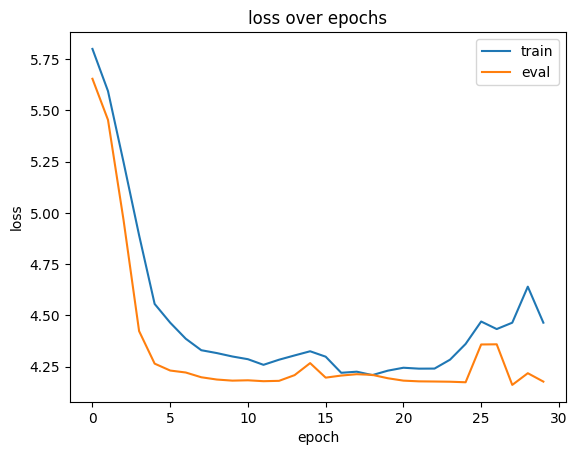

In [50]:
# Plot MSE
plt.plot(train_losses, label="train")
plt.plot(eval_losses, label="eval")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("loss over epochs")
plt.legend()
plt.show()

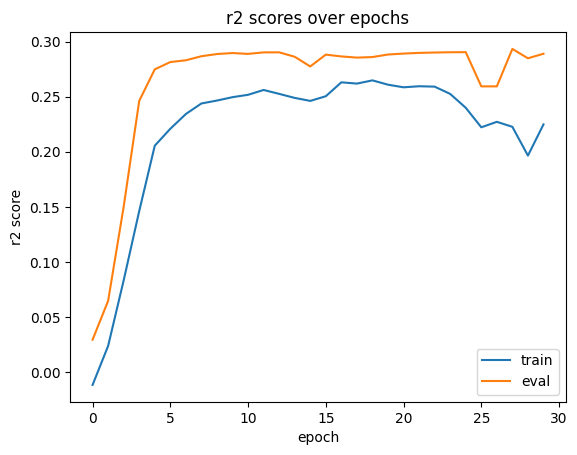

In [51]:
# Plot R2 scores
plt.plot(train_r2_scores, label="train")
plt.plot(eval_r2_scores, label="eval")
plt.xlabel("epoch")
plt.ylabel("r2 score")
plt.title("r2 scores over epochs")
plt.legend()
plt.show()

In [350]:
# smoothed model
loss, epoch_r2_score = evaluate_weighted(model, eval_dataloader, device=device)
print(f"Eval loss: {loss:.4f}")
print(f"Eval R2: {epoch_r2_score:.4f}")

Eval loss: 4.2473
Eval R2: 0.2815


In [135]:
years = [2021, 2022]

prediction_df = df.copy()
prediction_df = prediction_df[prediction_df["year"].isin(years)]
prediction_df["predicted_normalized_return"] = prediction_df.apply(
    lambda row: predict_returns(
        model, row["area_code"], row["year"], row["asset_type"]
    ),
    axis=1,
)
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
]

,year,area_code,predicted_normalized_return,unit_price_median_pct_chg,unit_price_median_pct_chg_normalized_yearly
35359,2020,1610,-0.225865,-0.083333,-0.183792
35360,2020,1559,-0.126823,-0.056604,-0.163653
35361,2020,40345,0.299982,0.254167,0.212992
35362,2020,11211,-0.082083,0.255589,0.215278
35363,2020,27204,-0.095639,-0.153846,-0.236919
...,...,...,...,...,...
43476,2022,19202,-0.279620,0.291667,0.122768
43477,2022,40205,-0.291991,-0.133333,-0.361959
43478,2022,35344,-0.761920,1.200000,1.158755
43479,2022,33215,0.369334,-0.191489,-0.428288


In [38]:
prediction_df[
    [
        "year",
        "area_code",
        "predicted_normalized_return",
        metric_pct_chg,
        normalized_metric_pct_chg,
    ]
].to_csv(model_output_data_path, index=False)

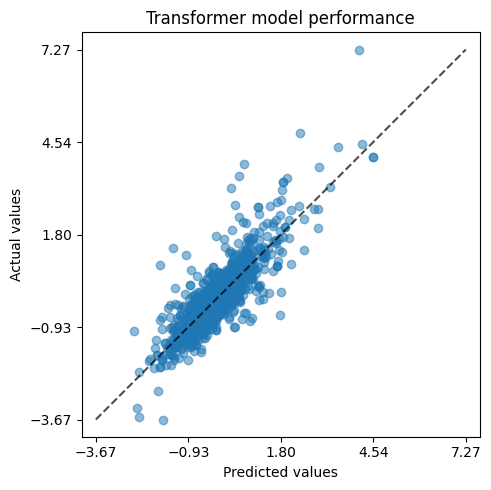

In [39]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="actual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

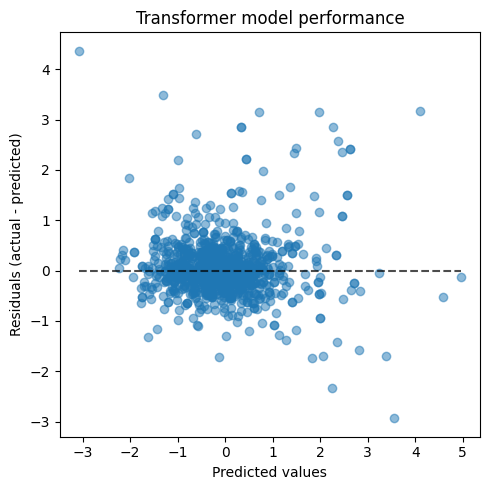

In [40]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    prediction_df[normalized_metric_pct_chg],
    prediction_df["predicted_normalized_return"],
    kind="residual_vs_predicted",
    ax=ax,
    scatter_kwargs={"alpha": 0.5},
)
ax.set_title("Transformer model performance")
plt.tight_layout()

In [221]:
model

TimeSeriesTransformerModel(
  (embedding): Linear(in_features=11, out_features=256, bias=True)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (linear): Linear(in_features=256, out_features=1, bias=True)
)

In [319]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

Number of parameters: 51393
